In [161]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [175]:
# import the raw data
articles_df = pd.read_csv('../data/article_scraped_data.csv').dropna(subset=['document'])

# VADER

We model the sentiment of an article using the VADER (Valence Aware Dictionary and sEntiment Reasoner), as this has shown to having promising results in a similar setting, as found by (Ko & Chang, 2021). This implementation of vader is assisted through a Geeks for Geeks instructional article (GeeksforGeeks, 2024)

Ko, C.-R., & Chang, H.-T. (2021). LSTM‐based sentiment analysis for stock price forecast. PeerJ Computer Science, 7(1), e408. https://doi.org/10.7717/peerj-cs.408 

GeeksforGeeks. (2024, December 11). Python sentiment analysis using VADER – Using Python. https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

In [176]:
from nltk.stem import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # apply lemminization first


# Initialize the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# Define a function to calculate all VADER sentiment scores
def get_vader_sentiment_scores(document):
    """Clean the text, apply lemminization, and calculate VADER sentiment scores"""
    # document = [PorterStemmer().stem(word) for word in document.split()]
    # print(lemminized_document)
    return analyzer.polarity_scores(document)
# change the column names to positive, negative, neutral, and compound
sentiment_scores = articles_df['document'].apply(get_vader_sentiment_scores)

# Convert the sentiment_scores Series to a DataFrame and rename columns
sentiment_scores_df = sentiment_scores.apply(pd.Series).rename(
    columns={'pos': 'vader_positive', 'neg': 'vader_negative', 'neu': 'vader_neutral', 'compound': 'vader_compound'}
)

# bind them side by side to the original dataframe
articles_df = pd.concat([articles_df, sentiment_scores_df], axis=1)


# BERT (finBERT)

VADER's rule-based approach relies on fixed lexicons and doesn't fully capture the context-dependent sentiment embedded in text, whereas BERT's deep contextual embeddings allow it to discern and represent nuanced sentiment more effectively.
FinBERT is a domain-specific adaptation of the BERT model, fine-tuned on financial texts to accurately determine the sentiment expressed in this particular context (Araci, 2019). This model was retrieved using the huggingface library (ProsusAI, n.d.)

While this sounds better, it relies on the data being labelled, making training on a large corupus of data unfeasible. We therefore utilise the finbert-tone pretrained transformer which is the FinBERT model trained on 10,000 manually annotated documents (positive, negative, neutral) sentences from analyst reports.

Araci, D. T. (2019). FinBERT: Financial sentiment analysis with pre‐trained language models [Master’s thesis, University of Amsterdam]. https://doi.org/10.48550/arXiv.1908.10063

ProsusAI. (n.d.). FinBERT [Model]. Hugging Face. Retrieved March 27, 2025, from https://huggingface.co/ProsusAI/finbert

```
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
```

In [74]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)



Device set to use cpu


In [ ]:
def calculate_sentiment_scores(document):
    """Truncate document (so that it doesnt exceed 512 token limit) and perform sentiment analysis."""
    truncated_text = tokenizer.decode(tokenizer.encode(document, max_length=510, truncation=True))
    return nlp(truncated_text)  # Use the NLP pipeline directly

articles_df[['bert_sentiment_label', 'bert_sentiment_score']] = articles_df['document'].apply(
    lambda doc: pd.Series({
        'bert_sentiment_label': nlp(tokenizer.decode(tokenizer.encode(doc, max_length=510, truncation=True)))[0]['label'],
        'bert_sentiment_score': nlp(tokenizer.decode(tokenizer.encode(doc, max_length=510, truncation=True)))[0]['score']
    })
)

In [178]:
articles_df

,title,author,date_string,sector,stock_codes,document,url,vader_negative,vader_neutral,vader_positive,vader_compound,bert_sentiment_score
0,Surprise Budget will show longer term deficits,John Beveridge,"March 23, 2025",Hot Topics,[],This week’s Federal Budget should be the econo...,https://smallcaps.com.au/surprise-budget-will-...,0.056,0.810,0.134,0.9952,0.900166
1,Weekly wrap: supermarket stocks boost market’s...,John Beveridge,"March 22, 2025",Hot Topics,[],It’s official – supermarket prices are rising ...,https://smallcaps.com.au/weekly-wrap-supermark...,0.039,0.833,0.128,0.9968,0.856789
2,DRC suspension of exports expected to result i...,Colin Hay,"March 21, 2025",Hot Topics,[],Reports that the Democratic Republic of the Co...,https://smallcaps.com.au/drc-suspension-export...,0.064,0.864,0.071,0.3400,0.958730
3,GreenHy2 secures H2Core deal to advance superc...,Colin Hay,"March 21, 2025",Energy,['ASX:H2G'],Solid state hydrogen storage developer GreenHy...,https://smallcaps.com.au/greenhy2-h2core-deal-...,0.040,0.828,0.133,0.9722,0.999994
4,Compumedics reaches $20m in Chinese MEG sales ...,Colin Hay,"March 21, 2025",Biotech,['ASX:CMP'],Brain research technologies specialist Compume...,https://smallcaps.com.au/compumedics-chinese-m...,0.000,0.873,0.127,0.9886,0.999999
...,...,...,...,...,...,...,...,...,...,...,...,...
1702,Nova Minerals targets NASDAQ dual listing to i...,Colin Hay,"February 29, 2024",Mining,['ASX:NVA'],Nova Minerals (ASX: NVA) has confirmed its pro...,https://smallcaps.com.au/nova-minerals-targets...,0.007,0.866,0.127,0.9959,0.991211
1703,Radiopharm Theranostics doses first patient in...,Imelda Cotton,"February 29, 2024",Biotech,['ASX:RAD'],Biotechnology company Radiopharm Theranostics ...,https://smallcaps.com.au/radiopharm-theranosti...,0.066,0.839,0.095,0.6452,0.998893
1704,Boss Energy on track to produce first drum of ...,Imelda Cotton,"February 29, 2024",Mining,['ASX:BOE'],Boss Energy (ASX: BOE) has started commissioni...,https://smallcaps.com.au/boss-energy-on-track-...,0.012,0.882,0.106,0.9805,0.574822
1705,VHM accelerates transition from explorer to de...,Colin Hay,"February 29, 2024",Mining,['ASX:VHM'],VHM Limited (ASX: VHM) continues to achieve it...,https://smallcaps.com.au/vhm-accelerates-trans...,0.006,0.891,0.102,0.9945,0.999860


## Comparison of Sentiment Distribution Across the corpus

- vader is much smaller compute time (8.3s vs 15mins)
- vader doesnt consider sentence structure
- we look at the difference in distribution of sentiment

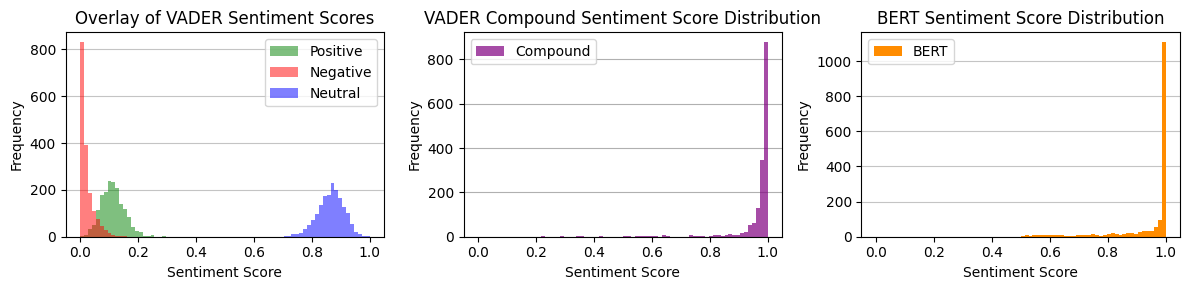

In [180]:

# Define the bins manually
bins = np.linspace(0, 1, 75)  # 30 bins between 0 and 1
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Histogram for positive, negative, and neutral sentiment scores
axes[0].hist(articles_df['vader_positive'], bins=bins, color='green', alpha=0.5, label='Positive', zorder=2)
axes[0].hist(articles_df['vader_negative'], bins=bins, color='red', alpha=0.5, label='Negative', zorder=2)
axes[0].hist(articles_df['vader_neutral'], bins=bins, color='blue', alpha=0.5, label='Neutral', zorder=2)
axes[0].set_title('Overlay of VADER Sentiment Scores')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].legend(loc='best')
axes[0].grid(axis='y', alpha=0.75, zorder=1)

# Histogram for compound sentiment scores
axes[1].hist(articles_df['vader_compound'], bins=bins, color='purple', alpha=0.7, label='Compound', zorder=2)
axes[1].set_title('VADER Compound Sentiment Score Distribution')
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].legend(loc='best')
axes[1].grid(axis='y', alpha=1, zorder=1)

# Histogram for BERT sentiment scores
axes[2].hist(articles_df['bert_sentiment_score'], bins=bins, color='darkorange', alpha=1, label='BERT', zorder=2)
axes[2].set_title('BERT Sentiment Score Distribution')
axes[2].set_xlabel('Sentiment Score')
axes[2].set_ylabel('Frequency')
axes[2].legend(loc='best')
axes[2].grid(axis='y', alpha=0.75, zorder=1)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


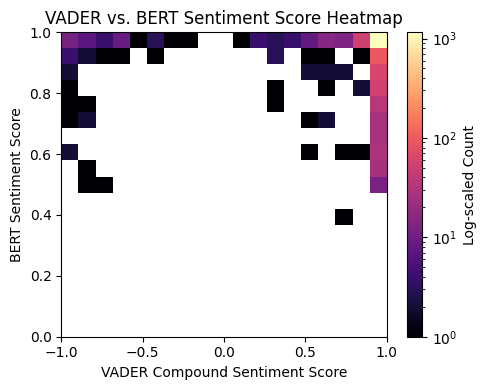

In [182]:
# Set up the figure
fig, ax = plt.subplots(figsize=(5, 4))

# 2D histogram with a logarithmic colormap
bin_count = 20  # Increase bin count for better resolution
# Create a 2D histogram with a logarithmic colormap
hist, xedges, yedges, image = ax.hist2d(
    x=articles_df['vader_compound'],
    y=articles_df['bert_sentiment_score'],
    bins=[np.linspace(-1, 1, bin_count), np.linspace(0, 1, bin_count)],
    cmap='magma',
    norm=LogNorm(),
    cmin=1,
)
# Add a colorbar to indicate density
cbar = fig.colorbar(image, ax=ax)
cbar.set_label('Log-scaled Count')

# Adjust labels
ax.set_title("VADER vs. BERT Sentiment Score Heatmap")
ax.set_xlabel('VADER Compound Sentiment Score')
ax.set_ylabel('BERT Sentiment Score')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

articles_df.to_csv('../data/sentiment_data.csv', index=False)

